# Lstm Simple approach

Epoch 1/150


c:\Users\Shadow\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0225 - val_loss: 0.0194
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0151
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0150
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_loss: 0.0161
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0155
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0159
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0166
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0167
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0173
Epoch 10/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0167
Epoch 11/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0172
Epoch 12/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_l

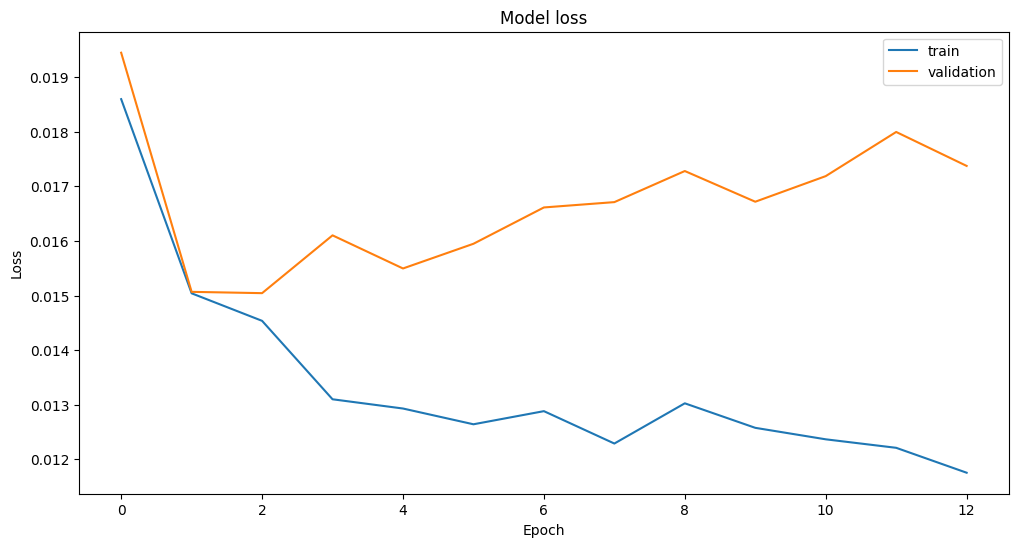

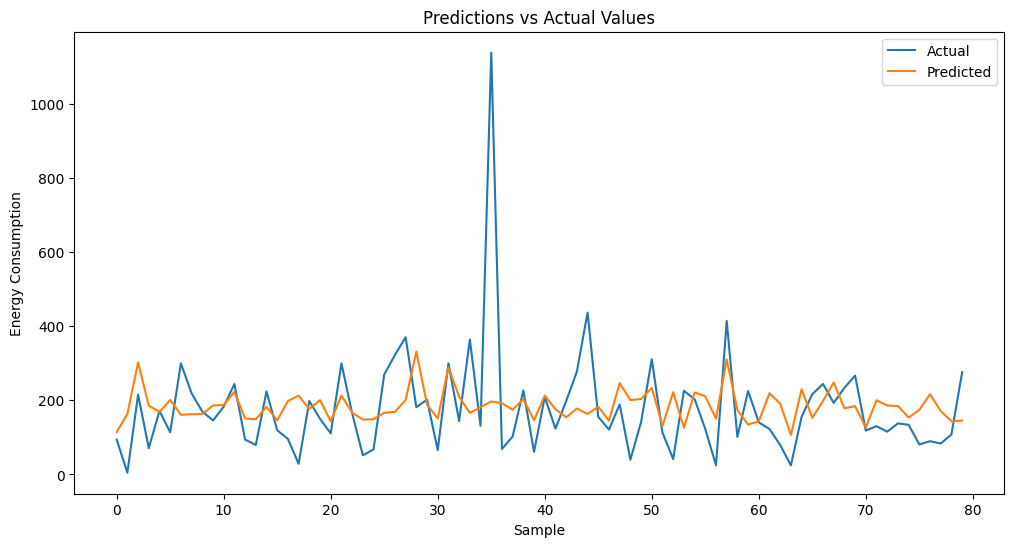

In [11]:
# LSTM SIMPLE SIMPLE APPROACH

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'C:\\Users\\Shadow\\Desktop\\GIT_PE\\survey_data\\survey_data.csv'
data = pd.read_csv(file_path)

# Drop the 'Meter No' column as it's not relevant
data.drop('Meter No', axis=1, inplace=True)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'  # Explicitly define the target variable

# Impute missing values with zero for appliance counts
data[appliance_columns] = data[appliance_columns].fillna(0)

# Neighboring Average for Monthly Units
unit_columns = [
    'post_21_july_unit', 'post_21_august_unit', 'post_21_sep_unit', 'post_21_oct_unit',
    'post_21_nov_unit', 'post_21_dec_unit', 'post_22_jan_unit', 'post_22_feb_unit',
    'pre_23_jan_unit', 'pre_23_feb_unit', 'pre_23_mar_unit',
    'pre_23_apr_unit', 'pre_23_may_unit', 'pre_23_june_unit', 'pre_23_jul_unit',
    'pre_23_aug_unit', 'pre_23_sep_unit', 'pre_23_oct_unit', 'pre_23_nov_unit'
]
for i in range(1, len(unit_columns)-1):
    data[unit_columns[i]] = data[unit_columns[i]].fillna(
        (data[unit_columns[i-1]] + data[unit_columns[i+1]]) / 2
    )

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

selected_features = appliance_columns + unit_columns
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])

# Combine features and target back into a single array
data_scaled_combined = np.hstack((data_scaled, target_scaled))

# Creating sequences for LSTM using the selected features and the target
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

n_steps = 3  # Number of past months to consider
X, y = create_sequences(data_scaled_combined, n_steps)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and compile the LSTM model 2 layer 
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
batch_size = 32
epochs = 150
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Calculate additional metrics
y_pred = model.predict(X_test)
y_test_inverse = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = target_scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
r2 = r2_score(y_test_inverse, y_pred_inverse)

# Display results: 
print(f'Test Loss: {test_loss}, \nMean Absolute Error (MAE): {mae}, \nRoot Mean Squared Error (RMSE): {rmse}, \nR-squared (R²): {r2}')


# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training_validation_loss_simple.png')
plt.show()

# Plotting predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('Predictions vs Actual Values')
plt.ylabel('Energy Consumption')
plt.xlabel('Sample')
plt.legend()
plt.savefig('actual_vs_predicted_simple.png')
plt.show()


# Lstm Complex

Epoch 1/150


c:\Users\Shadow\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0285 - val_loss: 0.0151
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - val_loss: 0.0160
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - val_loss: 0.0155
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 10/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - val_loss: 0.0162
Epoch 11/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - val_loss: 0.0155
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 
3/3 ━━━━━━━━

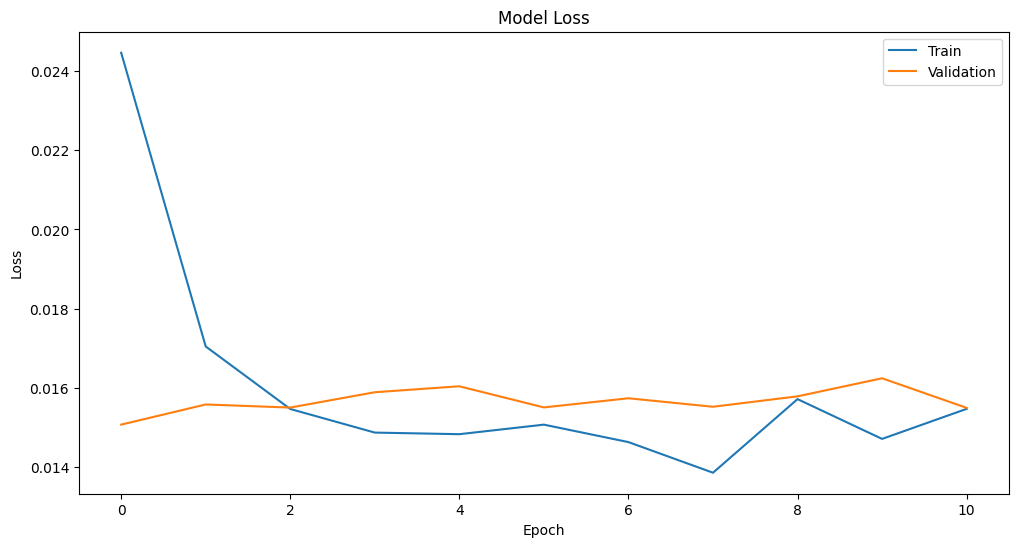

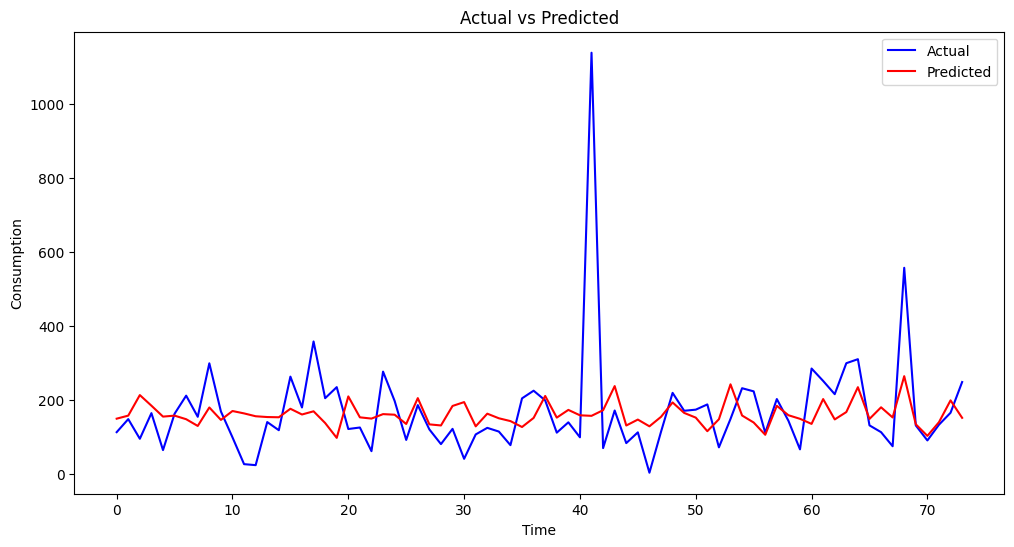

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = 'C:\\Users\\Shadow\\Desktop\\GIT_PE\\survey_data\\survey_data.csv'
data = pd.read_csv(file_path)

# Drop the 'Meter No' column as it's not relevant
data.drop('Meter No', axis=1, inplace=True)

# Define appliance columns and target variable
appliance_columns = ['Rooms', 'Fans', 'Lights', 'Freezes', 'Microwave Oven', 'Geyser', 'AC', 'Washing Machine', 'TV', 'PC', 'Induction Stove']
target_variable = 'pre_23_dec_unit'

# Impute missing values with zero for appliance counts
data[appliance_columns] = data[appliance_columns].fillna(0)

# Neighboring Average for Monthly Units
unit_columns = [
    'post_21_july_unit', 'post_21_august_unit', 'post_21_sep_unit', 'post_21_oct_unit',
    'post_21_nov_unit', 'post_21_dec_unit', 'post_22_jan_unit', 'post_22_feb_unit',
    'pre_23_jan_unit', 'pre_23_feb_unit', 'pre_23_mar_unit',
    'pre_23_apr_unit', 'pre_23_may_unit', 'pre_23_june_unit', 'pre_23_jul_unit',
    'pre_23_aug_unit', 'pre_23_sep_unit', 'pre_23_oct_unit', 'pre_23_nov_unit'
]
for i in range(1, len(unit_columns)-1):
    data[unit_columns[i]] = data[unit_columns[i]].fillna(
        (data[unit_columns[i-1]].shift(1) + data[unit_columns[i+1]].shift(-1)) / 2
    )

# Normalize the dataset
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

selected_features = appliance_columns + unit_columns
data_scaled = feature_scaler.fit_transform(data[selected_features])
target_scaled = target_scaler.fit_transform(data[[target_variable]])

# Combine scaled features and target
data_scaled = np.hstack((data_scaled, target_scaled))

# Creating sequences with a length of 30
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
batch_size = 32  # Appropriate for your dataset size
epochs = 150  # A higher number of epochs to allow sufficient learning
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])


# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate additional metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Display results
print(f'Test Loss: {test_loss}, \nMean Absolute Error (MAE): {mae}, \nRoot Mean Squared Error (RMSE): {rmse}, \nR-squared (R²): {r2}')

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training_validation_loss.png')
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual')
plt.plot(y_pred_rescaled, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.savefig('actual_vs_predicted.png')
plt.show()
